In [1]:
# Import libraries
import pandas as pd
import numpy as np

import sklearn
from sklearn import linear_model

import matplotlib
from matplotlib import pyplot as plt
showfig = True

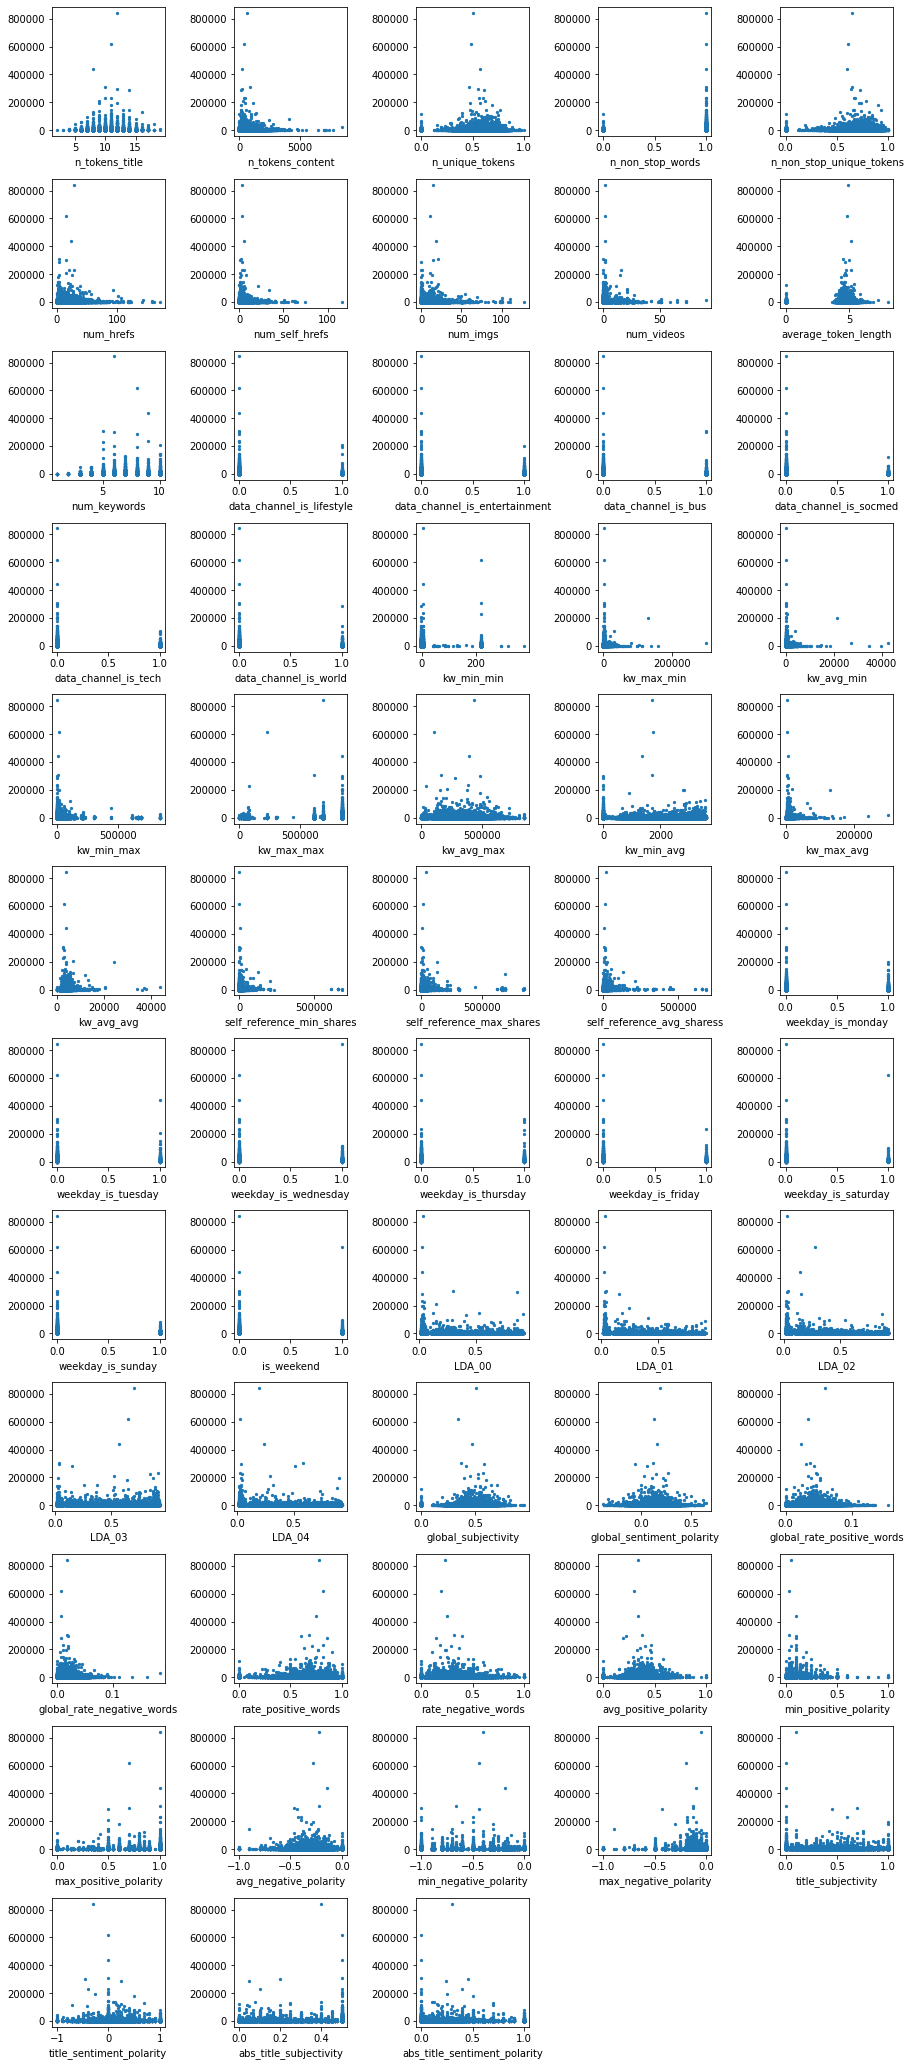

In [2]:
X1 = pd.read_csv("X1.csv")
Y1 = pd.read_csv("Y1.csv",header=None,names =['shares'])

if showfig:
    fig = plt.figure(figsize=(6.4*2,4.8*6))
    gs  = fig.add_gridspec(nrows=12, ncols=5)
    for (i,header) in enumerate(X1.columns):
        ax = fig.add_subplot(gs[int(i/5),i%5])
        ax.scatter(X1[header],Y1.values, s=5)
        ax.set_xlabel(header)
    fig.tight_layout()

X1_val = X1.values
Y1_val = Y1.values

In [3]:
# Prediction
def scoref1(ytrue, ypred, th):
    return sklearn.metrics.f1_score(ytrue>th, ypred>th)

def scoreregression(ytrue, ypred):
    scores = [
        scoref1(ytrue, ypred, th=th) for th in [ 500, 1400, 5000, 10000]
    ]
    return np.mean(scores)

In [13]:
def linear_regression(X1, Y1):
    #select features
    data = np.concatenate((np.transpose(X1[0:9999, :]),np.transpose(Y1[0:9999])))
    corr = np.corrcoef(data)
    ind = np.argpartition(corr[:][58], -4)[-4:]
    features = np.zeros((19822,2))
    tracker = 0
    for i in ind[0:-1]:
        features[:,tracker] = X1[:, i]
        tracker +=1

    # Create linear regression object
    regr = linear_model.LinearRegression()

    print(features.shape)

    # Train the model using the training sets
    regr.fit(features[0:9999,:], Y1[0:9999])

    # Make predictions using the testing set
    y_pred = regr.predict(features[:][10000:19000])
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # print('Mean squared error: %.2f'
    #   % mean_squared_error(Y1[10000:19000], y_pred))
    print(scoreregression(Y1[10000:19000], y_pred))

In [14]:
linear_regression(X1_val,Y1_val)

(19822, 2)
Coefficients: 
 [[-0.07240779  1.3622876 ]]
0.47871457217833696
